In [1]:
from rebin_data import RebinData
import numpy as np
import torch
import matplotlib.pyplot as plt
from read_fk_table import get_fk_table

In [2]:
# Read rebinned data
luminosity_factor = 2
init_bins = 20
min_num_events = 0
data =RebinData(luminosity_factor=luminosity_factor,init_rebinning=init_bins,min_num_events=min_num_events)

Enu,data,data_min,data_max, binwidth = data.rebin_eq_binwidth()

print('Enu =')
print(Enu)


print(f'pred = {data}')

num events = 1178.801437462901
Enu =
[ 323.75  622.5   921.25 1220.   1518.75 1817.5  2116.25 2415.   2713.75
 3012.5  3311.25 3610.   3908.75 4207.5  4506.25 4805.   5103.75 5402.5
 5701.25 6000.  ]
pred = [ 13.58424938 153.0550816  197.37275627 175.29044576 144.69299806
 120.60164907  95.83060069  73.16589893  55.53594658  41.67436626
  30.52583153  21.91234461  16.20536348  12.44419632   8.57067709
   6.25726288   4.65426131   3.45347595   2.32467331   1.64935839]


In [3]:
def compute_errors(pred,pred_min,pred_max):
    """Compute total sigma error on data and covariance matrix

    Args:
        pred (list): central data
        pred_min (list): minimum data
        pred_max (list): max data

    Returns:
        tuple: covariance matrix and total error
    """
    # compute systematic error on data
    delta_plus = pred_max - pred
    delta_min = pred_min- pred
    semi_diff = (delta_plus + delta_min) / 2
    average = (delta_plus - delta_min) / 2
    sig_sys = np.sqrt(average * average + 2 * semi_diff * semi_diff)

    # compute covariance matrix of data
    sig_tot = sig_sys**2 + pred
    cov_matrix = sig_tot 
    cov_matrix = np.diag(sig_tot)
    cov_matrix = np.linalg.inv(cov_matrix)
    cov_matrix = torch.tensor(cov_matrix, dtype=torch.float32,requires_grad=False)

    return sig_sys, sig_tot, cov_matrix

sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max)

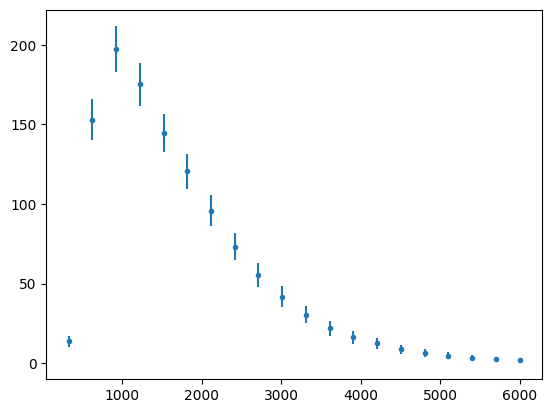

In [4]:
plt.errorbar(Enu,data,yerr = np.sqrt(sig_tot),fmt = '.')
plt.show()

In [5]:
x_alpha, fk_table = get_fk_table(filename = 'fk_table_20')
# x_alpha_more_bins, fk_table_more_bins = get_fk_table(filename = 'fk_table_100')

/Users/jukkajohn/Masterscriptie/Codes/ML_fit_neutrinos/src/ML_fit_neutrinos/read_fk_table.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


torch.Size([20])


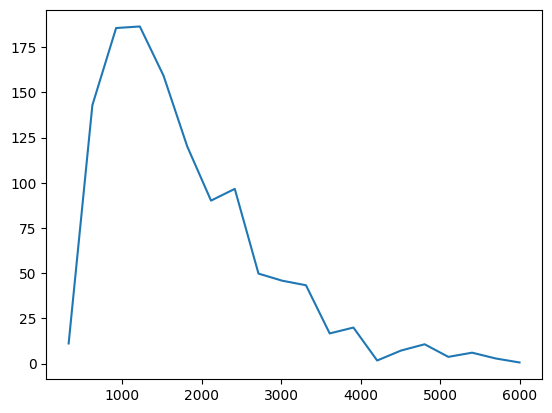

torch.Size([20, 1])


In [6]:

REPLICAS  = 1
def generate_MC_replicas():
    """Generate level 2 data MC replicas for the NN fit by adding a level 1 and then a level 2 gaussian noise to the data

    Returns:
        list: MC replica data
    """

    r_sys = np.random.normal(0,sig_sys)
    r_stat = np.random.normal(0,np.sqrt(data))

    
    MC_data = []
    data_level1 = data + r_sys + r_stat

    for _ in range(REPLICAS):
        r_sys = np.random.normal(0,sig_sys)
        r_stat = np.random.normal(0,np.sqrt(data))

        data_level2 = data_level1 + r_sys + r_stat
        data_level2 = torch.tensor(data_level2, dtype=torch.float32, requires_grad=False)
        print(data_level2.shape)
        
        MC_data.append(data_level2)
    plt.plot(Enu,data_level2)
    plt.show()
    pred_level1 = torch.tensor(data_level1, dtype=torch.float32)
    return MC_data,pred_level1

MC_data,data_level1 = generate_MC_replicas()

r_sys = np.random.normal(0,sig_sys)
r_stat = np.random.normal(0,np.sqrt(data))
MC_data = []
data = torch.tensor(data, dtype=torch.float32).view(-1,1)
MC_data.append(data)
pred_level1 = data + r_sys + r_stat
print(data.shape)

In [7]:
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,1)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        # y = self.relu(y)
        # y = self.hidden2(y)
        # y = self.relu(y)
        # y = self.hidden3(y)
        
        

        return y

In [8]:
import torch.nn as nn
class CustomPreprocessing(nn.Module):
    def __init__(self, alpha,beta,gamma):
        super(CustomPreprocessing, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

    def forward(self, x):
        # Ensure x values are within valid range (0 < x < 1)
        # x = torch.clamp(x, 1e-6, 1 - 1e-6)  # Avoid division by zero or log errors
        # if x<0.02:
        # return self.gamma*(1 - x) ** self.beta * x ** self.alpha * -np.log(1-x + 1e-6)
        return self.gamma*(1 - x) ** self.beta * x ** self.alpha * -np.log(1-x + 1e-6)
        # else:
        #     return self.gamma*(1 - x) ** self.alpha * x ** self.beta

        # if x < 10**-3 or x > 4*10**1:
            # return torch.tensor(0, dtype=torch.float32)
        # else:
            # return self.alpha * (x/x)

In [9]:
# Combine the preprocessing and MLP in a single model
class PreprocessedMLP(nn.Module):
    def __init__(self, alpha, beta, gamma,l1, l2, l3):
        super(PreprocessedMLP, self).__init__()
        self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
        self.mlp = SimplePerceptron(l1, l2, l3)

    def forward(self, x):
        x = self.preprocessing(x)
        x = self.mlp(x)
        return x

In [10]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()
    def forward(self,pred,data):
        # diff = (pred - data).squeeze()
        # loss = (torch.matmul(cov_matrix, diff)).squeeze()
        
        # loss = (1/pred.size(0) * torch.dot(diff,loss)).squeeze()
        # print(pred.shape)
        # print(data.shape)
        # diff = pred - data  # Assuming pred and data already have compatible shapes
        # loss = torch.matmul(cov_matrix, diff)  # This should give the desired shape

        # # Compute the dot product directly
        # loss = (1 / pred.size(0)) * torch.dot(diff, loss)

        # loss = loss.squeeze()

        diff = pred - data  # Assuming pred and data already have compatible shapes
        loss = torch.matmul(cov_matrix, diff)  # This should give the desired shape

        # Compute the dot product directly
        loss = (1 / pred.size(0)) * torch.dot(diff.view(-1), loss.view(-1))
        
        return loss

torch.Size([50, 1])
reduced chi^2 level 2 = 25.956090927124023
reduced chi^2 level 1 = 25.956090927124023
Constrained alpha: -2.463033437728882
Constrained beta: 3.2059099674224854
Constrained gamma: 499.9665832519531


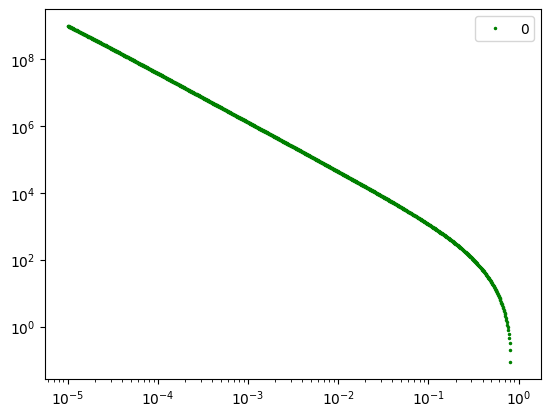

In [15]:
fits = []


for i in range(REPLICAS):

    # Instantiate the model
    alpha = 0.5  # Example alpha value
    beta = 0.7  # Example beta value
    gamma = 500
    l1=8
    l2=40
    l3=20

    model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)

    # Loss and optimizer
    criterion = CustomLoss()
    # criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()

    nepochs = 2000 # numer of epoches, i.e. times we iterate through the entire dataset
    print(x_alpha.shape)

    for epoch in range(nepochs):

        optimizer.zero_grad()

        y_pred = model(x_alpha)  # Use all data directly
        y_pred = torch.matmul(fk_table,y_pred) * binwidth
        loss = criterion(y_pred, data)

        loss.backward()
        optimizer.step()
        
    
    red_chi_square_level1 = criterion(y_pred,data)

    print(f"reduced chi^2 level 2 = {loss}")
    print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
    x_alpha_more_bins = np.logspace(-5,0,1000)
    x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)

    y_pred = model(x_alpha_more_bins).detach().numpy().flatten()
    x_fit = np.logspace(-5,0,1000)
    plt.plot(x_fit,y_pred,'go',label=i,markersize=1.5)
    print(f"Constrained alpha: {model.preprocessing.alpha.item()}")
    print(f"Constrained beta: {model.preprocessing.beta.item()}")
    print(f"Constrained gamma: {model.preprocessing.gamma.item()}")

    
#     if loss <100000:
#         unitary_fk_table = 1
#         y_pred = model(x_alpha_more_bins,fk_table_more_bins).detach().numpy().flatten()

#         # y_pred = y_pred.detach().numpy()
#         # y_pred = y_pred.flatten()

#         fits.append(y_pred)
# # plt.plot(Enu,data_level1,'go',label='best fit',markersize=1.5)
# plt.ylim(0,10**3)
plt.xscale('log')
plt.yscale('log')
# plt.xlim(0.02,1)
# plt.ylim(10**-2,10**3)
plt.legend()
plt.show()


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_73767/2661747182.py:3: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10**5)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_73767/2661747182.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


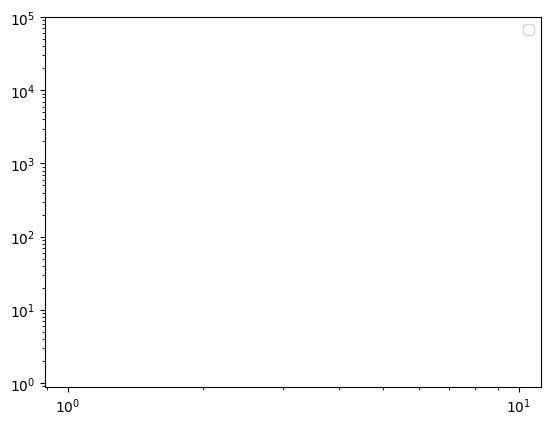

In [12]:
plt.xscale('log')
plt.yscale('log')
plt.ylim(0,10**5)
plt.legend()
plt.show()

In [13]:
# MC means and MC errors
mean_fit = np.mean(fits,axis=0)
sigma_fit = np.std(fits,axis=0)
sigma_fit = sigma_fit.flatten()

/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (1000,) and (1,)

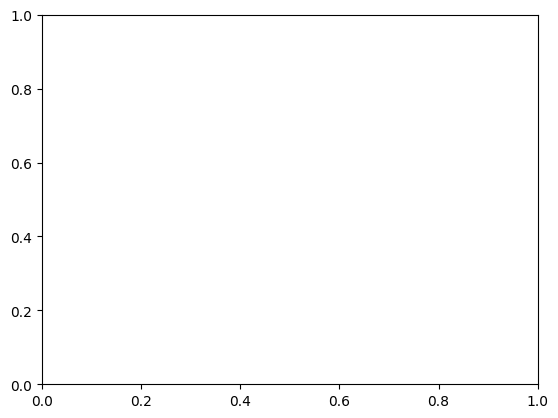

In [14]:
x_fit = np.logspace(-5,0,1000)
# x_fit  = x_fit[1:]
plt.plot(x_fit,mean_fit,'go',label='best fit',markersize=1.5)
# plt.fill_between(x_fit,mean_fit+sigma_fit,mean_fit-sigma_fit,label='1 sigma error',color = 'red',alpha=0.6)
# plt.plot(Enu,mean_fit,'go',label='best fit',markersize=1.5)
# plt.fill_between(Enu,mean_fit+sigma_fit,mean_fit-sigma_fit,label='1 sigma error',color = 'red',alpha=0.6)
# print(data)
# print(Enu)
# plt.errorbar(Enu,data,yerr = np.sqrt(sig_tot),label = 'mean data',fmt = '.')
# plt.xlabel('Enu')
# plt.ylabel('N_int')
# plt.legend()    

# plt.savefig('level_2_ML_fit.pdf')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0,10**5)
plt.show()


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_68619/3263714188.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(Enu,mean_fit/mean_fit,'go',label='best fit')


ValueError: x and y must have same first dimension, but have shapes (15,) and (1000,)

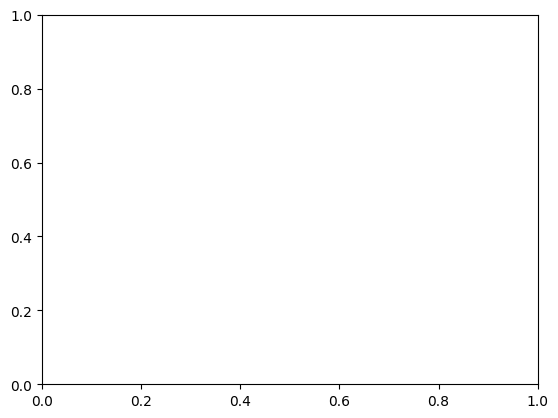

In [ ]:
# This plot is to see the relative error of the ML fit
# plt.plot(x_fit,mean_fit/mean_fit,'go',label='best fit')
# plt.fill_between(x_fit,(mean_fit+sigma_fit)/mean_fit,(mean_fit-sigma_fit)/mean_fit,label='1 sigma error',color = 'blue',alpha=0.3)

plt.plot(Enu,mean_fit/mean_fit,'go',label='best fit')
plt.fill_between(Enu,(mean_fit+sigma_fit)/mean_fit,(mean_fit-sigma_fit)/mean_fit,label='1 sigma error',color = 'blue',alpha=0.3)

plt.errorbar(Enu,data/data,yerr = np.sqrt(sig_tot)/data,label = 'mean data',fmt = '.')


plt.xlabel('Enu')
plt.ylabel('N_int')
plt.legend()
plt.ylim(0,2)
plt.show()